# Digit Recognizer

Learn computer vision fundamentals with the famous MNIST data

In [1]:
import tensorflow as tf
print(tf.__version__)

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

2.1.0


In [2]:
def show_mnist(images, labels, predicted_labels=None):
    """Функция по отображению сэмпла"""
    
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")

def show_progress(history: dict):
    """Функция по acc и loss"""
    
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1,2,1)    
    plt.plot(history["accuracy"],label='train accuracy')
    plt.plot(history["val_accuracy"], label='test accuracy')
    ax2 = plt.subplot(1,2,2)
    plt.plot(history["loss"],label='train_loss')
    plt.plot(history["val_loss"],label='test_loss')
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()

## Загрузка данных

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv('train.csv')
data.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Вектора целевой переменной и трейна/теста
X = data[data.columns[1:].to_list()].values
Y = data[data.columns[0]].values

# Преобразуем вектор в картинку
x_show_img = X.reshape([-1, 28, 28])

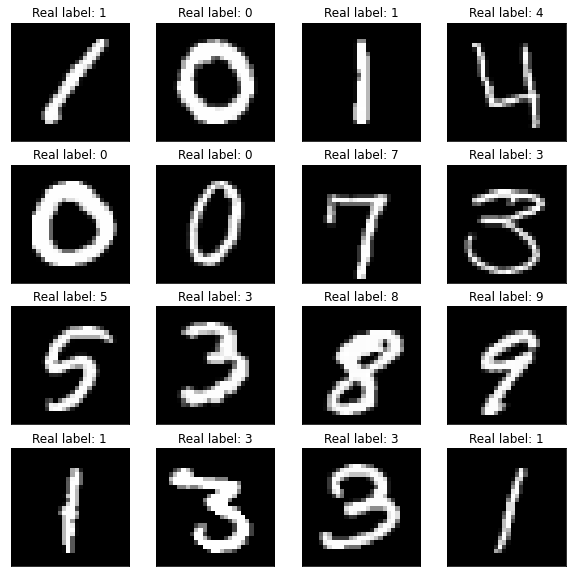

In [6]:
show_mnist(x_show_img, Y)

In [7]:
from sklearn.model_selection import train_test_split

# Тренировочная и валидационные выборки
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
x_train, x_test = x_train / 255.0, x_test / 255.0

In [8]:
# Путь для записи прогресса и лучших параметров модели
path = Path("data/model_1")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()

cpt_filename = "best_checkpoint.hdf5"  
cpt_path =str(path / cpt_filename)

In [9]:
# Модель 1
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(600, input_shape=(784,), activation='sigmoid'))
model.add(tf.keras.layers.Dense(200, activation='sigmoid'))
model.add(tf.keras.layers.Dense(100, activation='sigmoid'))
model.add(tf.keras.layers.Dense(400, activation='sigmoid'))
model.add(tf.keras.layers.Dense(50, activation='sigmoid'))
model.add(tf.keras.layers.Dense(80, activation='sigmoid'))
model.add(tf.keras.layers.Dense(20, activation='sigmoid'))
model.add(tf.keras.layers.Dense(10, activation='sigmoid')) 

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"]) 
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, verbose=0, batch_size=64, shuffle=True, callbacks=[checkpoint])

Графики обучения:

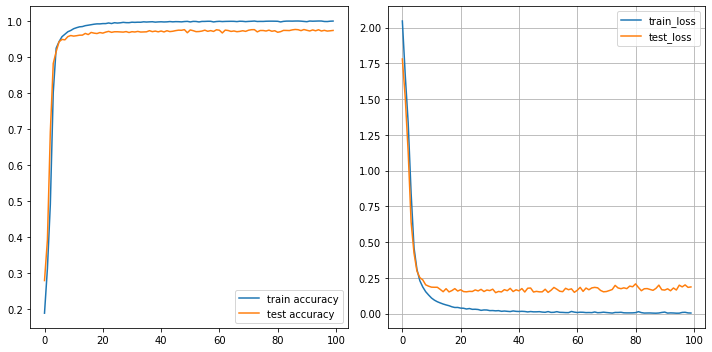

In [10]:
show_progress(history.history)

In [11]:
# Accuracy на валидации лучшей модели
restored_model = tf.keras.models.load_model(cpt_path)
loss, acc = restored_model.evaluate(x_test, y_test)
print(f"Accuracy of restored model {acc*100 :.2f}%")

6300/6300 [==============================] - 1s 174us/sample - loss: 0.1627 - accuracy: 0.9760
Accuracy of restored model 97.60%


Сравнение предсказаний с реальными классами на тесте:

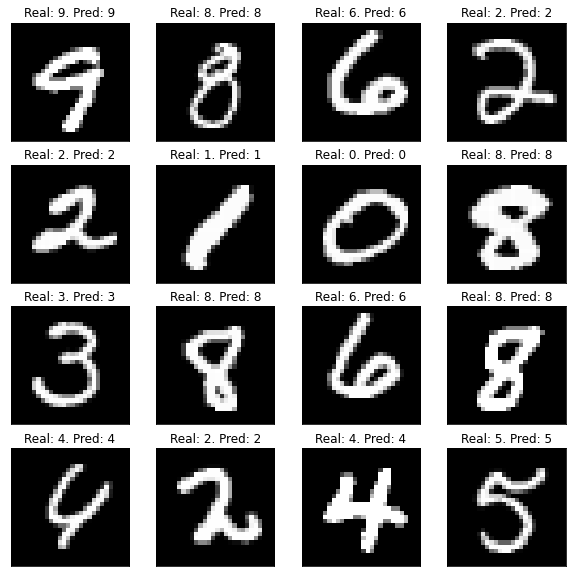

In [12]:
predicted_labels = restored_model.predict_classes(x_test)
idxs = np.random.choice(np.arange(len(x_test)), 16, replace=False)
show_mnist(x_test[idxs].reshape((-1, 28, 28)), y_test[idxs], predicted_labels[idxs])

In [13]:
# Тестовый датасет для kaggle
test_to_submit = pd.read_csv('test.csv')
test_to_submit = test_to_submit.values / 255.0

In [14]:
# Предсказание
predicted_labels = restored_model.predict_classes(test_to_submit)

In [15]:
# Загрузка в формат для Kaggle
sub_df = pd.DataFrame([np.arange(1, predicted_labels.shape[0]+1), predicted_labels]).T
sub_df.columns = ['ImageId' ,'Label']
sub_df = sub_df.astype(int)
sub_df.to_csv('Submission.csv', index=False)